# Implement a Neural Network for Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import time


In this project, I will implement a neural network that performs sentiment analysis for a binary classification problem. Specifically:

1. Load the book review data set.
2. Create training and test datasets.
3. Transform the training and test text data using a TF-IDF vectorizer. 
4. Construct a neural network
5. Train the neural network.
6. Compare the model's performance on the training data vs test data.

## Part 1:  Load the Data Set

I will work with the book review data set that contains book reviews extracted from Amazon.com reviews.

In [2]:
filename = os.path.join(os.getcwd(), "data", "bookReviews.csv")
df = pd.read_csv(filename, header=0)

In [3]:
df.head()

,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


In [4]:
df.shape

(1973, 2)

## Part 2: Create Training and Test Data Sets

### Create Labeled Examples

* Get the `Positive_Review` column from DataFrame `df` and assign it to the variable `y`. This will be our label.
* Get the `Review` column from  DataFrame `df` and assign it to the variable `X`. This will be our feature. 


In [5]:
y = df['Positive Review']
X = df['Review']

In [6]:
X.head()

0    This was perhaps the best of Johannes Steinhof...
1    This very fascinating book is a story written ...
2    The four tales in this collection are beautifu...
3    The book contained more profanity than I expec...
4    We have now entered a second time of deep conc...
Name: Review, dtype: object

In [7]:
X.shape

(1973,)

### Split Labeled Examples into Training and Test Sets
    

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1234)


In [9]:
X_train.head()

1369    As my brother said when flipping through this ...
1366    Cooper's book is yet another warm and fuzzy ma...
385     I have many robot books and this is the best a...
750     As China re-emerges as a dominant power in the...
643     I have been a huge fan of Michael Crichton for...
Name: Review, dtype: object

## Part 3:  Implement TF-IDF Vectorizer to Transform Text


##### I will transform the features into numerical vectors using `TfidfVectorizer`. 

In [10]:
# 1. Create a TfidfVectorizer object 
tfidf_vectorizer = TfidfVectorizer()

# 2. Fit the vectorizer to X_train
tfidf_vectorizer.fit(X_train)

# 3. Using the fitted vectorizer, transform the training data 
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# 4. Using the fitted vectorizer, transform the test data 

X_test_tfidf = tfidf_vectorizer.transform(X_test)


Run the code cell below to see the vocabulary size.

In [11]:
vocabulary_size = len(tfidf_vectorizer.vocabulary_)

print(vocabulary_size)

19029


## Part 4: Construct a Neural Network


### Step 1.  Define Model Structure

For the neural network structure, I will create an input layer, three hidden layers and an output layer:

* <b>Input layer</b>: The input layer will have the input shape corresponding to the vocabulary size. 
* <b>Hidden layers</b>: The three hidden layers will hage widths (number of nodes) of 64, 32, and 16. They will utilize the ReLu activation function. 
* <b>Output layer</b>: The output layer will have a width of 1. The output layer will utilize the sigmoid activation function to map the output to a probability between 0.0 and 1.0. 

To construct the neural network model using Keras, I will use the Keras `Sequential` class to group a stack of layers, and the `Dense` class to create each layer. 

In [12]:
# 1. Create model object
nn_model = keras.Sequential()


# 2. Create the input layer and add it to the model object: 

# Create input layer:
input_layer = keras.layers.InputLayer(input_shape=(vocabulary_size,), name = 'input')

# Add input_layer to the model object:

nn_model.add(input_layer)



# 3. Create the first hidden layer and add it to the model object:

# Create input layer:
hidden_layer_1 = keras.layers.Dense(units=64, activation='relu', name = 'hl1')

# Add hidden_layer_1 to the model object:
nn_model.add(hidden_layer_1)


# 4. Create the second layer and add it to the model object:

# Create input layer:
hidden_layer_2 = keras.layers.Dense(units=32, activation='relu', name = 'hl2')

# Add hidden_layer_2 to the model object:
nn_model.add(hidden_layer_2)


# 5. Create the third layer and add it to the model object:

# Create input layer:
hidden_layer_3 = keras.layers.Dense(units=16, activation='relu', name = 'hl3')

# Add hidden_layer_3 to the model object:
nn_model.add(hidden_layer_3)


# 6. Create the output layer and add it to the model object:

# Create input layer:
output_layer = keras.layers.Dense(units=1, activation='sigmoid')

# Add output_layer to the model object:
nn_model.add(output_layer)


# Print summary of neural network model structure
nn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hl1 (Dense)                  (None, 64)                1217920   
_________________________________________________________________
hl2 (Dense)                  (None, 32)                2080      
_________________________________________________________________
hl3 (Dense)                  (None, 16)                528       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,220,545
Trainable params: 1,220,545
Non-trainable params: 0
_________________________________________________________________


### Step 2. Define the Optimization Function

I will create a stochastic gradient descent optimizer using  `keras.optimizers.SGD()`, and specify a learning rate of 0.1 using the `learning_rate` parameter. 

In [13]:
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)

### Step 3. Define the Loss Function

I will reate a binary cross entropy loss function using `keras.losses.BinaryCrossentropy()`. 

In [14]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

### Step 4. Compile the Model

Now I will package the network architecture with the optimizer, the loss function using and accuracy evaluation metric using the `compile()` method. 

In [15]:
nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

## Part 5. Fit the Model on the Training Data

In [16]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))


I will fit the neural network model to the vectorized training data, and outputs both the training loss and accuracy and the validation loss and accuracy.

In [17]:
t0 = time.time() # start time

num_epochs = 50 #epochs

history = nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=num_epochs,verbose=0,callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=50)], validation_split = 0.2) 

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))



Epoch [50/ 50], Loss: 0.0013, Accuracy: 1.0000, Val_loss: 0.5593, Val_accuracy: 0.8038
Elapsed time: 20.81s


### Visualize the Model's Performance Over Time

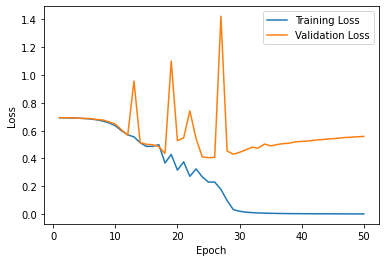

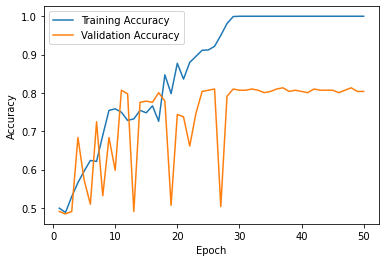

In [18]:
# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Part 6. Evaluate the Performance on the Test Data

I will evaluate the model's performance on our test data using Keras method `evaluate()`, which will return the loss and accuracy score of our model on our test data.

In [19]:
loss, accuracy = nn_model.evaluate(X_test_tfidf.toarray(), y_test)


print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

13/13 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.8228
Loss:  0.5623419284820557 Accuracy:  0.8227847814559937
